In [1]:
import numpy as np
import cv2
import torch
from time import time
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils import data
from datagen import Datagen
from image_utils import *
from v2_93 import *
import math
import datetime

device = 'cuda'
ckpt_dir = 'E:/ModelCkpts/StabNet-multigrid-future_frames'
starting_epoch = 0
H,W,C = shape = (256,256,3)
batch_size = 4
EPOCHS = 10
grid_h, grid_w = 15,15

In [2]:
from models import transformer
class StabNet(nn.Module):
    def __init__(self,trainable_layers = 10):
        super(StabNet, self).__init__()
        # Load the pre-trained ResNet model
        vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')
        # Extract conv1 pretrained weights for RGB input
        rgb_weights = vgg19.features[0].weight.clone() #torch.Size([64, 3, 3, 3])
        # Calculate the average across the RGB channels
        tiled_rgb_weights = rgb_weights.repeat(1,5,1,1) 
        # Change size of the first layer from 3 to 9 channels
        vgg19.features[0] = nn.Conv2d(15,64, kernel_size=3, stride=1, padding=1, bias=False)
        # set new weights
        vgg19.features[0].weight = nn.Parameter(tiled_rgb_weights)
        # Determine the total number of layers in the model
        total_layers = sum(1 for _ in vgg19.parameters())
        # Freeze the layers except the last 10
        for idx, param in enumerate(vgg19.parameters()):
            if idx > total_layers - trainable_layers:
                param.requires_grad = True
            else:
                param.requires_grad = False
        # Remove the last layer of ResNet
        self.encoder = nn.Sequential(*list(vgg19.children())[0][:-1])
        self.regressor = nn.Sequential(nn.Linear(512,2048),
                                       nn.ReLU(),
                                       nn.Linear(2048,1024),
                                       nn.ReLU(),
                                       nn.Linear(1024,512),
                                       nn.ReLU(),
                                       nn.Linear(512, ((grid_h + 1) * (grid_w + 1) * 2)))
        #self.regressor[-1].bias.data.fill_(0)
        total_resnet_params = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
        total_regressor_params = sum(p.numel() for p in self.regressor.parameters() if p.requires_grad)
        print("Total Trainable mobilenet Parameters: ", total_resnet_params)
        print("Total Trainable regressor Parameters: ", total_regressor_params)
        print("Total Trainable parameters:",total_regressor_params + total_resnet_params)
    
    def forward(self, x_tensor):
        x_batch_size = x_tensor.size()[0]
        x = x_tensor[:, :3, :, :]

        # summary 1, dismiss now
        x_tensor = self.encoder(x_tensor)
        x_tensor = torch.mean(x_tensor, dim=[2, 3])
        x = self.regressor(x_tensor)
        x = x.view(x_batch_size,grid_h + 1,grid_w + 1,2)
        return x

In [3]:
stabnet = StabNet(trainable_layers=10).to(device).train()
optimizer = torch.optim.Adam(stabnet.parameters(),lr = 2e-5)


Total Trainable mobilenet Parameters:  2360320
Total Trainable regressor Parameters:  3936256
Total Trainable parameters: 6296576


In [4]:
out = stabnet(torch.randn(1,15,256,256).float().to(device))
out.shape

torch.Size([1, 16, 16, 2])

In [5]:
ckpts = os.listdir(ckpt_dir)
if ckpts:
    ckpts = sorted(ckpts, key=lambda x: datetime.datetime.strptime(x.split('_')[2].split('.')[0], "%H-%M-%S"), reverse=True)
    # Get the filename of the latest checkpoint
    latest = os.path.join(ckpt_dir, ckpts[0])
    # Load the latest checkpoint
    state = torch.load(latest)
    stabnet.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    starting_epoch = state['epoch'] + 1
    optimizer.param_groups[0]['lr'] *= 0.1
    print('Loaded weights from', latest)
    print('Reduced learning rate to', optimizer.param_groups[0]['lr'])

Loaded weights from E:/ModelCkpts/StabNet-multigrid-future_frames\stabnet_2023-11-01_23-17-37.pth
Reduced learning rate to 5.000000000000001e-07


In [6]:
def get_warp(net_out,img):
    '''
    Inputs:
        net_out: torch.Size([batch_size,grid_h +1 ,grid_w +1,2])
        img: image to warp
    '''
    grid_y, grid_x = torch.meshgrid(torch.linspace(-1,1, grid_h + 1),
                                    torch.linspace(-1,1, grid_h + 1),
                                    indexing='ij')
    src_grid = torch.stack([grid_x,grid_y],dim = -1).unsqueeze(0).repeat(batch_size,1,1,1).to(device)
    new_grid = src_grid + net_out
    grid_upscaled = F.interpolate(new_grid.permute(0,-1,1,2),size = (height,width), mode = 'bilinear',align_corners= True)
    warped = F.grid_sample(img, grid_upscaled.permute(0,2,3,1),align_corners=True)
    return warped ,grid_upscaled.permute(0,2,3,1)

In [7]:
def temp_loss(warped0,warped1, flow):
    #prev  warped1
    #curr  warped0
    temp = dense_warp(warped1, flow)
    return F.l1_loss(warped0,temp)

def shape_loss(net_out):
    grid_y, grid_x = torch.meshgrid(torch.linspace(-1,1, grid_h + 1),
                                    torch.linspace(-1,1, grid_h + 1),
                                    indexing='ij')
    grid_tensor = torch.stack([grid_x,grid_y],dim = -1).unsqueeze(0).repeat(batch_size,1,1,1).to(device)
    new_grid = grid_tensor + net_out

    #Lintra
    vt0 = new_grid[:, :-1, 1:, :]
    vt0_original = grid_tensor[:, :-1, 1:, :]
    vt1 = new_grid[:, :-1, :-1, :]
    vt1_original = grid_tensor[:, :-1, :-1, :]
    vt = new_grid[:, 1:, :-1, :]
    vt_original = grid_tensor[:, 1:, :-1, :]
    alpha = vt - vt1
    s = torch.norm(vt_original - vt1_original, dim=-1) / torch.norm(vt0_original - vt1_original, dim=-1)
    vt01 = vt0 - vt1
    beta = s[..., None] * torch.stack([vt01[..., 1], -vt01[..., 0]], dim=-1)
    norm = torch.norm(alpha - beta, dim=-1, keepdim=True)
    Lintra = torch.sum(norm) / (((grid_h + 1) * (grid_w + 1)) * batch_size)

    # Extract the vertices for computation
    vt1_vertical = new_grid[:, :-2, :, :]
    vt_vertical = new_grid[:, 1:-1, :, :]
    vt0_vertical = new_grid[:, 2:, :, :]

    vt1_horizontal = new_grid[:, :, :-2, :]
    vt_horizontal = new_grid[:, :, 1:-1, :]
    vt0_horizontal = new_grid[:, :, 2:, :]

    # Compute the differences
    vt_diff_vertical = vt1_vertical - vt_vertical
    vt_diff_horizontal = vt1_horizontal - vt_horizontal

    # Compute Linter for vertical direction
    Linter_vertical = torch.mean(torch.norm(vt_diff_vertical - (vt_vertical - vt0_vertical), dim=-1))

    # Compute Linter for horizontal direction
    Linter_horizontal = torch.mean(torch.norm(vt_diff_horizontal - (vt_horizontal - vt0_horizontal), dim=-1))

    # Combine Linter for both directions
    Linter = Linter_vertical + Linter_horizontal

    # Compute the shape loss
    shape_loss = Lintra + 20 * Linter

    return shape_loss

def feature_loss(features, warp_field):
    stable_features = ((features[:, :, 0, :] + 1) / 2) * torch.tensor([255, 255], dtype=torch.float).to(device)
    unstable_features = ((features[:, :, 1, :] + 1) / 2) * torch.tensor([255, 255], dtype=torch.float).to(device)
    
    # Clip the features to the range [0, 255]
    stable_features = torch.clamp(stable_features, min=0, max=255)
    unstable_features = torch.clamp(unstable_features, min=0, max=255)
    
    warped_unstable_features = unstable_features + warp_field[:, unstable_features[:, :, 1].long(), unstable_features[:, :, 0].long(), :]
    loss = torch.mean(torch.sqrt(torch.sum((stable_features - warped_unstable_features) ** 2,dim = -1)))
    
    return loss

In [8]:
def draw_features(image,features,color):
    drawn = image.copy()
    for point in features:
        x,y = point
        cv2.circle(drawn, (int(x),int(y)), 2, color, -1)
    return drawn

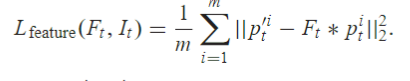

In [9]:
class IterDataset(data.IterableDataset):
    def __init__(self, data_generator):
        super(IterDataset, self).__init__()
        self.data_generator = data_generator

    def __iter__(self):
        return iter(self.data_generator())
generator = Datagen(shape = (H,W),txt_path = './trainlist.txt')
iter_dataset = IterDataset(generator)
data_loader = data.DataLoader(iter_dataset, batch_size=batch_size)


In [10]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/vgg_16x16/')

In [11]:
cv2.namedWindow('window',cv2.WINDOW_NORMAL)
# Training loop
for epoch in range(starting_epoch,EPOCHS):  
    # Generate the data for each iteration
    running_loss = 0
    for idx,batch in enumerate(data_loader):
        start = time()
        St, St_1, Igt , flow,features = batch
        # Move the data to GPU if available
        St = St.to(device)
        St_1 = St_1.to(device)
        Igt = Igt.to(device)
        It = St[:,6:9,...].to(device)
        It_1 = St_1[:,6:9,...].to(device)
        flow = flow.to(device)
        features = features.to(device)
        # Forward pass through the Siamese Network
        
        transform0 = stabnet(St)
        transform1 = stabnet(St_1)

        warped0,warp_field = get_warp(transform0,It)
        warped1,_ = get_warp(transform1,It_1)
        # Compute the losses
        #stability loss
        pixel_loss = 10 * F.mse_loss(warped0, Igt)
        feat_loss = feature_loss(features,warp_field)
        stability_loss = pixel_loss + feat_loss
        #shape_loss
        sh_loss = shape_loss(transform0)
        #temporal loss
        warped2 = dense_warp(warped1, flow)
        temp_loss =  10 * F.mse_loss(warped0,warped2)
        # Perform backpropagation and update the model parameters
        optimizer.zero_grad()
        total_loss =  stability_loss + sh_loss + temp_loss
        total_loss.backward()
        optimizer.step()

        
        means = np.array([0.485, 0.456, 0.406],dtype = np.float32)
        stds = np.array([0.229, 0.224, 0.225],dtype = np.float32)

        img = warped0[0,...].detach().cpu().permute(1,2,0).numpy()
        img *= stds
        img += means
        img = np.clip(img * 255.0,0,255).astype(np.uint8)

        img1 = Igt[0,...].cpu().permute(1,2,0).numpy()
        img1 *= stds
        img1 += means
        img1 = np.clip(img1 * 255.0,0,255).astype(np.uint8)
        #draw features
        stable_features = ((features[:, :, 0, :] + 1) / 2) * torch.tensor([255, 255], dtype=torch.float).to(device)
        unstable_features = ((features[:, :, 1, :] + 1) / 2) * torch.tensor([255, 255], dtype=torch.float).to(device)
        # Clip the features to the range [0, 255]
        stable_features = torch.clamp(stable_features, min=0, max=255).cpu().numpy()
        unstable_features = torch.clamp(unstable_features, min=0, max=255).cpu().numpy()
        img = draw_features(img,unstable_features[0,...],color = (0,255,0))
        img1 = draw_features(img1,stable_features[0,...],color = (0,0,255))
        conc = cv2.hconcat([img,img1])
        cv2.imshow('window',conc)
        if cv2.waitKey(1) & 0xFF == ord('9'):
            break
        
        running_loss += total_loss.item()
        print(f"\rEpoch: {epoch}, Batch:{idx}, loss:{running_loss / (idx % 100 + 1)}\
        pixel_loss:{pixel_loss.item()}, feature_loss:{feat_loss.item()} ,temp:{temp_loss.item()}, shape:{sh_loss.item()}",end = "")
        if idx % 100 == 99:
            writer.add_scalar('training_loss',
                                running_loss / 100, 
                                epoch * 41328 // batch_size + idx)
            running_loss = 0.0
            # Get current date and time as a formatted string
            current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

            # Append the formatted date-time string to the model filename
            model_path = os.path.join(ckpt_dir, f'stabnet_{current_datetime}.pth')
            
            torch.save({'model': stabnet.state_dict(),
                        'optimizer' : optimizer.state_dict(),
                        'epoch' : epoch}
                        ,model_path)
        del St, St_1, It, Igt, It_1,flow,features
cv2.destroyAllWindows()

Epoch: 2, Batch:1193, loss:8.925530743091665        pixel_loss:4.0964155197143555, feature_loss:3.904881715774536 ,temp:4.310582160949707, shape:0.2874298393726349353

KeyboardInterrupt: 